# Imports

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit

import time

In [ ]:
tf.random.set_seed(0)

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



# Data loading

In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Pasteurizer_dataset/"

In [ ]:
train_df = pd.read_csv(path+ "centralized/train_set.csv")
test_df = pd.read_csv(path+ "centralized/test_set.csv")

In [ ]:
# No need for lagging variables for lstm

train_df.drop(['prev_water_temp','prev_can_temp'], axis=1, inplace=True)
test_df.drop(['prev_water_temp','prev_can_temp'], axis=1, inplace=True)

In [ ]:
feature_cols = ['paster_timeslot', 'curr_water_temp', 'bath_number', 'curr_bath_temp']

In [ ]:
test_df

,paster_id,paster_timeslot,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,214,20,38.71,1,44.0938,28.10
1,214,30,39.73,1,44.0000,28.27
2,214,40,40.57,1,43.9062,28.54
3,214,50,40.78,1,43.8187,28.80
4,214,60,41.36,1,43.7750,29.20
...,...,...,...,...,...,...
12173,149,2180,38.69,6,33.9562,43.46
12174,149,2190,38.64,6,33.9938,43.08
12175,149,2200,38.55,6,34.0563,42.69
12176,149,2210,38.31,6,34.1250,42.41


# Preparing Data

In [ ]:
train_df.head()

,paster_id,paster_timeslot,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,47,20,37.40,1,44.0188,30.47
1,47,30,38.69,1,43.9500,30.61
2,47,40,38.31,1,43.8500,30.85
3,47,50,37.73,1,43.7625,31.02
4,47,60,37.61,1,43.6813,31.27


In [ ]:
feature_cols = ['paster_timeslot', 'curr_water_temp', 'bath_number',
       'curr_bath_temp',]

In [ ]:
# min max normalization
train_df[feature_cols]=(train_df[feature_cols]-train_df[feature_cols].mean())/train_df[feature_cols].std()
test_df[feature_cols]=(test_df[feature_cols]-test_df[feature_cols].mean())/test_df[feature_cols].std()

In [ ]:
train_df

,paster_id,paster_timeslot,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,47,-1.676534,-1.976647,-2.020785,-1.072178,30.47
1,47,-1.659661,-1.822367,-2.020785,-1.079440,30.61
2,47,-1.642789,-1.867814,-2.020785,-1.089996,30.85
3,47,-1.625916,-1.937180,-2.020785,-1.099233,31.02
4,47,-1.609044,-1.951531,-2.020785,-1.107805,31.27
...,...,...,...,...,...,...
46967,65,1.309913,-2.029269,1.560681,-1.924587,38.67
46968,65,1.326786,-2.026877,1.560681,-1.918654,38.53
46969,65,1.343659,-2.028073,1.560681,-1.917335,38.43
46970,65,1.360531,-2.031661,1.560681,-1.910082,38.36


# Sequence Creation

In [ ]:
# Receives single engine dataframe, window size and features -> sequences of length==window_size
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [ ]:
# Generates sequences for multiple engines
def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['paster_id'].unique()
        
    data_gen = (list(gen_train_data(df[df['paster_id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['paster_id'].unique()
        
    label_gen = [gen_labels(df[df['paster_id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [ ]:
sequence_length = 20

gss = GroupShuffleSplit(n_splits=1, train_size=0.99, random_state=42)


for train_unit, val_unit in gss.split(train_df['paster_id'].unique(), groups=train_df['paster_id'].unique()):
    train_unit = train_df['paster_id'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = train_df['paster_id'].unique()[val_unit]

    train_split_array = gen_data_wrapper(train_df, sequence_length, feature_cols, train_unit)
    train_split_label = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'], train_unit)
    
    val_split_array = gen_data_wrapper(train_df, sequence_length, feature_cols, val_unit)
    val_split_label = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'], val_unit)

# create sequences train, test 
X_train = gen_data_wrapper(train_df, sequence_length, feature_cols)
y_train = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'])

X_test = gen_data_wrapper(test_df, sequence_length, feature_cols)
y_test = gen_label_wrapper(test_df, sequence_length, ['curr_can_temp'])

In [ ]:
X_train.shape

(42944, 20, 4)

# Model Definition

In [ ]:
# Defining LSTM model

model = tf.keras.Sequential()
# model.add(tf.keras.layers.Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(tf.keras.layers.InputLayer(input_shape=(sequence_length, 4)))

model.add(tf.keras.layers.LSTM(32, activation='tanh'))

# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))


In [ ]:
# InputLayer(input_shape=(20, 18)),  
(sequence_length, X_train.shape[2])

(20, 4)

# Training


In [ ]:
start = time.time()



model.compile(loss='mean_squared_error', optimizer="adam", metrics = 'mean_absolute_error')  # the model is recompiled to reset the optimizer

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=25,
                   batch_size=16)
end = time.time()
print(f"Training time {end - start:.2f} sec")

Epoch 1/25
2650/2650 [==============================] - 23s 7ms/step - loss: 504.4574 - mean_absolute_error: 17.2539 - val_loss: 10.5734 - val_mean_absolute_error: 2.5950
Epoch 2/25
2650/2650 [==============================] - 11s 4ms/step - loss: 2.9559 - mean_absolute_error: 1.2426 - val_loss: 0.4707 - val_mean_absolute_error: 0.4915
Epoch 3/25
2650/2650 [==============================] - 11s 4ms/step - loss: 1.2525 - mean_absolute_error: 0.7549 - val_loss: 0.6829 - val_mean_absolute_error: 0.5809
Epoch 4/25
2650/2650 [==============================] - 11s 4ms/step - loss: 1.1240 - mean_absolute_error: 0.7184 - val_loss: 0.5598 - val_mean_absolute_error: 0.5546
Epoch 5/25
2650/2650 [==============================] - 11s 4ms/step - loss: 1.1555 - mean_absolute_error: 0.7010 - val_loss: 0.5691 - val_mean_absolute_error: 0.5503
Epoch 6/25
2650/2650 [==============================] - 11s 4ms/step - loss: 1.0154 - mean_absolute_error: 0.6876 - val_loss: 0.3567 - val_mean_absolute_error: 0

# Evaluation

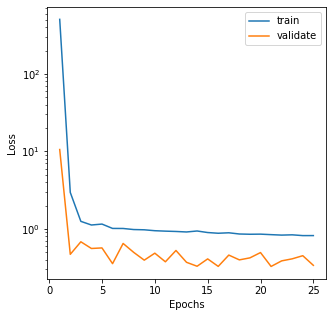

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

plot_loss(history)

In [ ]:

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat,squared=False)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, MSE:{}, MAE:{}, R2:{}'.format(label, rmse, mse, mae, variance))

In [ ]:
# predict and evaluate
y_hat_train = model.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = model.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:0.8881558179855347, MSE:0.788820743560791, MAE:0.5921048521995544, R2:0.98493776568025
test set RMSE:0.9648846983909607, MSE:0.9310024380683899, MAE:0.6566773056983948, R2:0.9833301202283141


In [ ]:
y_test

array([[41.66],
       [42.52],
       [43.26],
       ...,
       [42.69],
       [42.41],
       [42.17]], dtype=float32)

# Temp Plots

In [ ]:
test_df

,paster_id,paster_timeslot,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,214,-1.668826,-1.760130,-2.037563,-1.028705,28.10
1,214,-1.651990,-1.642320,-2.037563,-1.038268,28.27
2,214,-1.635153,-1.545301,-2.037563,-1.047831,28.54
3,214,-1.618317,-1.521046,-2.037563,-1.056752,28.80
4,214,-1.601481,-1.454056,-2.037563,-1.061207,29.20
...,...,...,...,...,...,...
12173,149,1.967827,-1.762440,1.565794,-2.062243,43.46
12174,149,1.984663,-1.768215,1.565794,-2.058410,43.08
12175,149,2.001499,-1.778610,1.565794,-2.052038,42.69
12176,149,2.018336,-1.806329,1.565794,-2.045034,42.41


In [ ]:
test_ids = list(pd.unique(test_df.paster_id))
# test_ids


In [ ]:
X_test_list = []
y_test_list = []


for id in test_ids:
  my_df = test_df.loc[ test_df.paster_id == id ]


  # gen_train_data(my_df, sequence_length, feature_cols)

  X_test = list(gen_train_data(my_df, sequence_length, feature_cols))
  y_test = list(my_df['curr_can_temp'])


  X_test_list.append(np.asarray(X_test))
  y_test_list.append(np.asarray(y_test)[sequence_length-1:])

In [ ]:
pred_list = []
for x in X_test_list:
  pred_list.append(model.predict(x))

In [ ]:
pred_list[0].shape

(179, 1)

In [ ]:
# 7,8,9,10,16,18,33, !!37!!, 38!, 47!

In [ ]:
def my_plot(true, prediction):
  line_thickness = 5
  plt.clf()
  plt.figure(figsize=(8,8))
  plt.plot(range(1, len(true)+1), true, label='true', linewidth=line_thickness, c='g')
  plt.plot(range(1, len(prediction)+1), prediction, label='predicted', linewidth=line_thickness, c='r')


  plt.xlabel('cycles')
  plt.ylabel('temperature(celcius)')
  plt.legend()
  plt.show()


<Figure size 432x288 with 0 Axes>

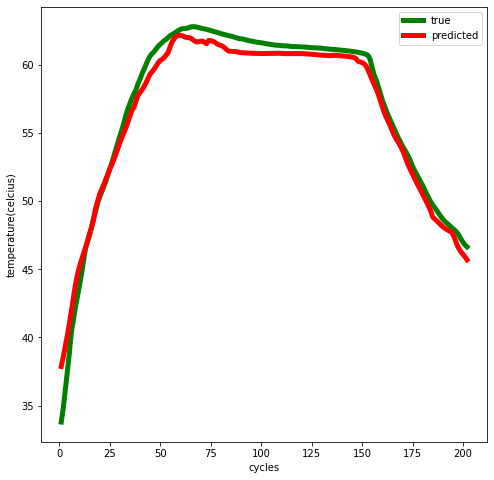

In [ ]:
pos = 37
my_plot(y_test_list[pos] , pred_list[pos])

0


<Figure size 432x288 with 0 Axes>

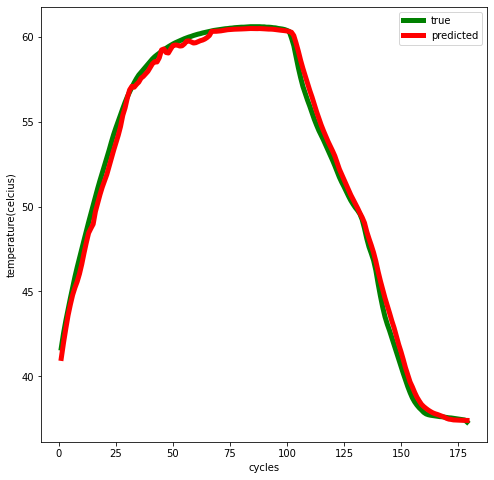

1


<Figure size 432x288 with 0 Axes>

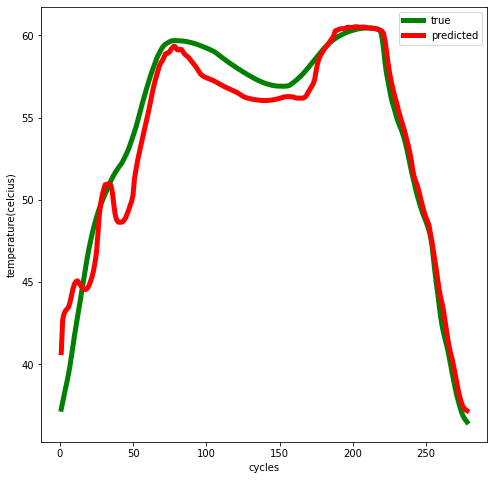

2


<Figure size 432x288 with 0 Axes>

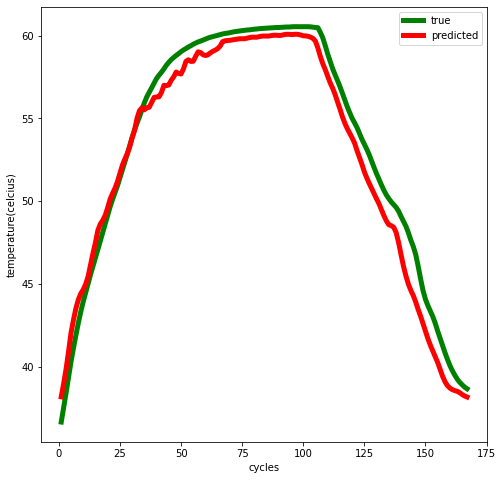

3


<Figure size 432x288 with 0 Axes>

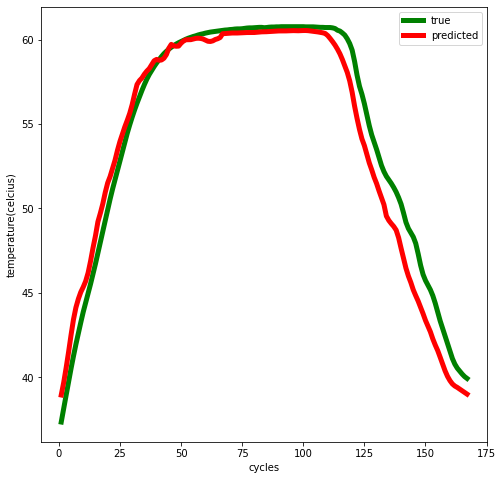

4


<Figure size 432x288 with 0 Axes>

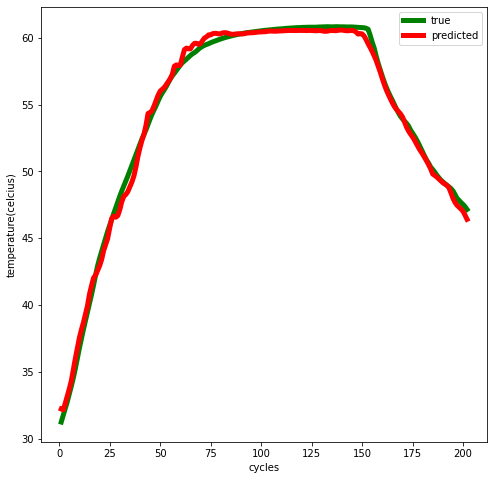

5


<Figure size 432x288 with 0 Axes>

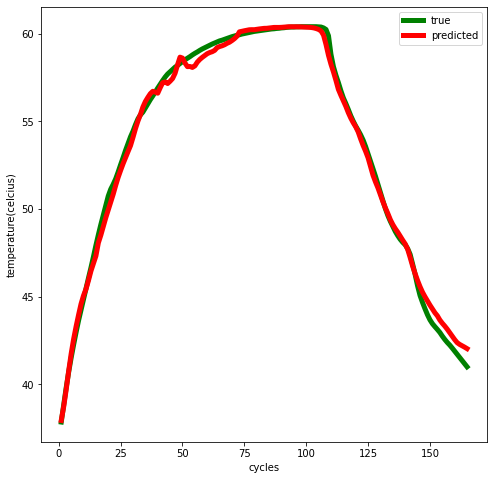

6


<Figure size 432x288 with 0 Axes>

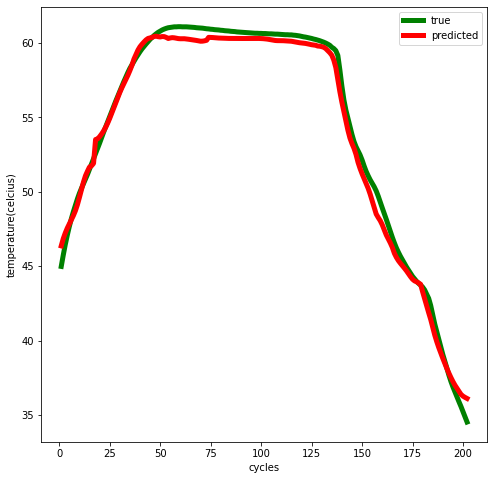

7


<Figure size 432x288 with 0 Axes>

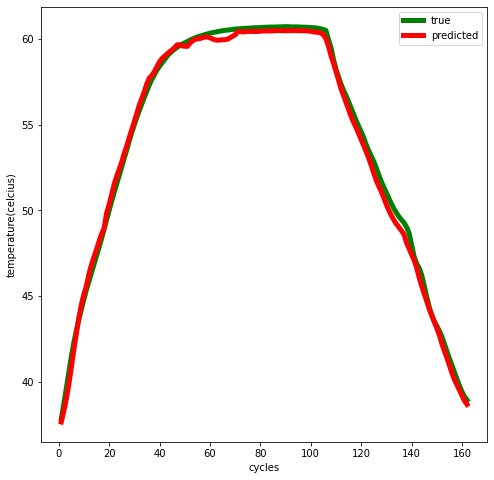

8


<Figure size 432x288 with 0 Axes>

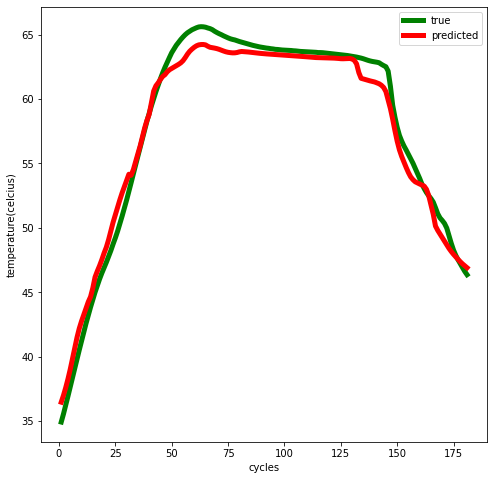

9


<Figure size 432x288 with 0 Axes>

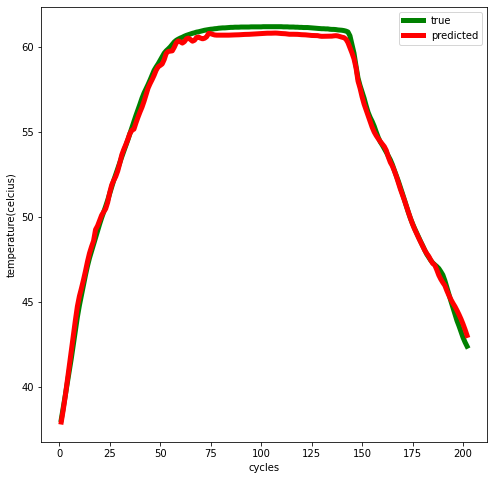

10


<Figure size 432x288 with 0 Axes>

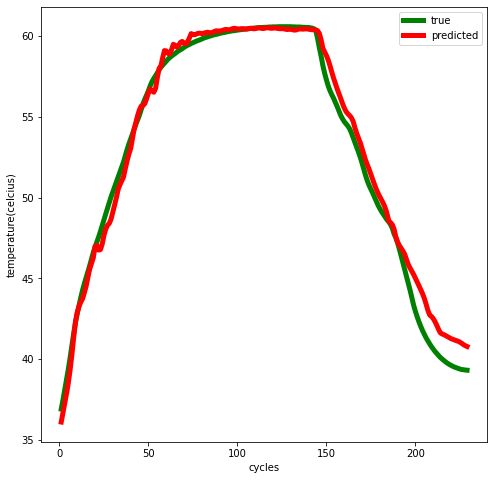

11


<Figure size 432x288 with 0 Axes>

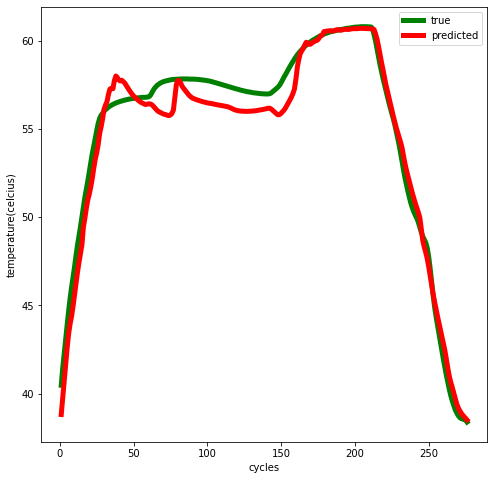

12


<Figure size 432x288 with 0 Axes>

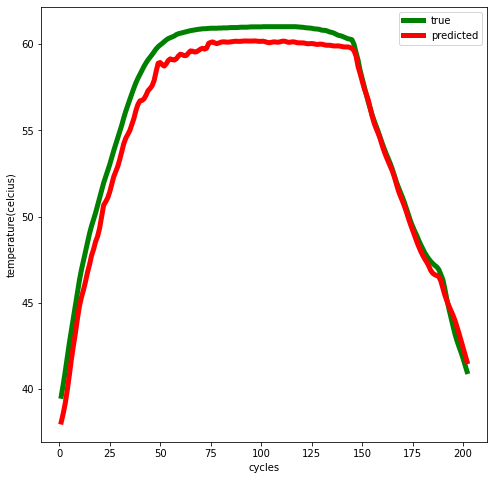

13


<Figure size 432x288 with 0 Axes>

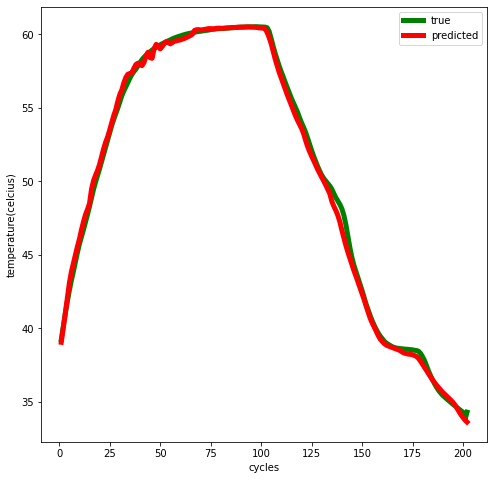

14


<Figure size 432x288 with 0 Axes>

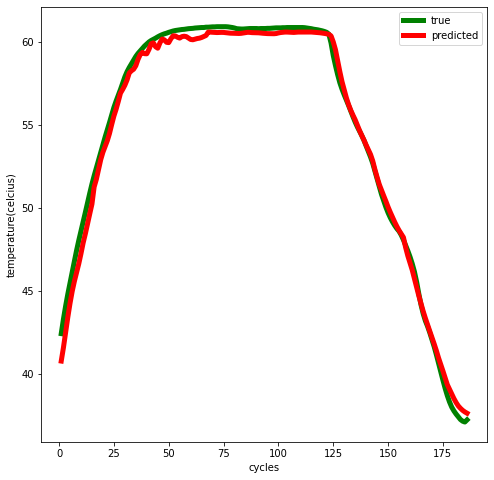

15


<Figure size 432x288 with 0 Axes>

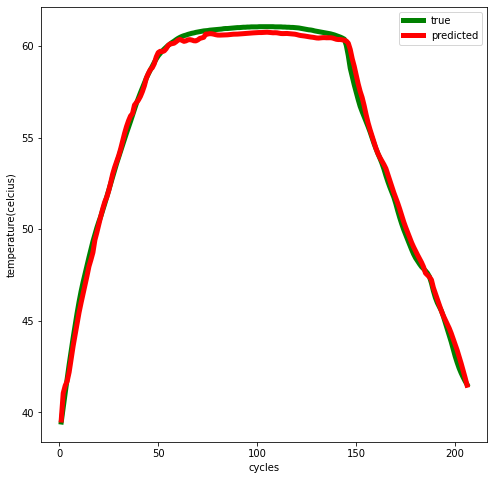

16


<Figure size 432x288 with 0 Axes>

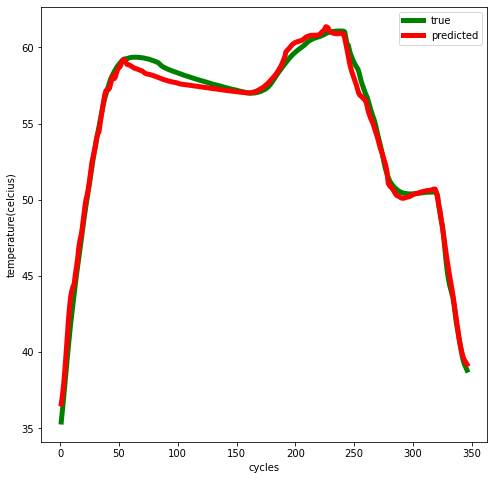

17


<Figure size 432x288 with 0 Axes>

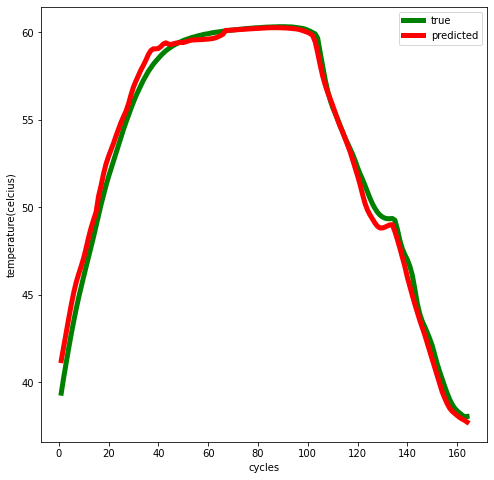

18


<Figure size 432x288 with 0 Axes>

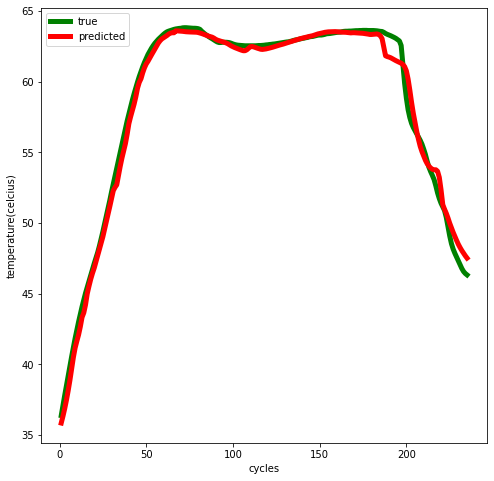

19


<Figure size 432x288 with 0 Axes>

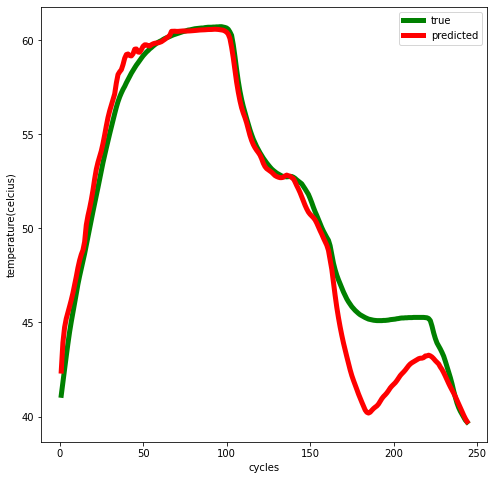

20


<Figure size 432x288 with 0 Axes>

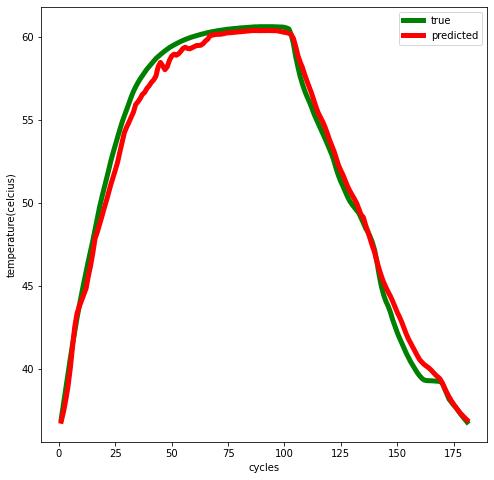

21


<Figure size 432x288 with 0 Axes>

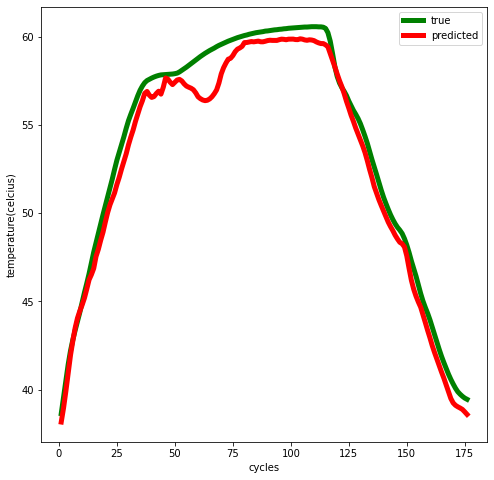

22


<Figure size 432x288 with 0 Axes>

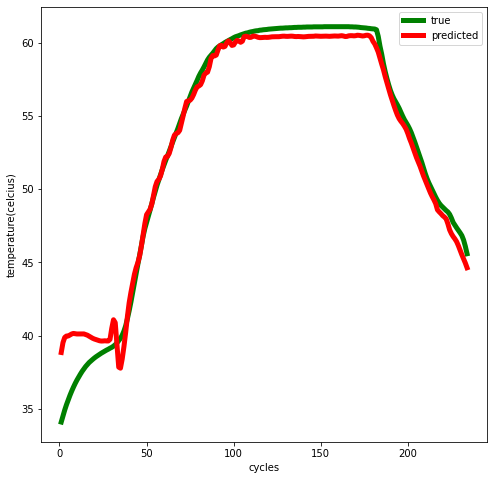

23


<Figure size 432x288 with 0 Axes>

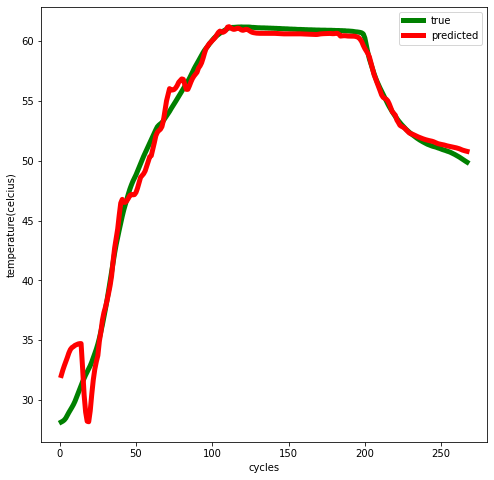

24


<Figure size 432x288 with 0 Axes>

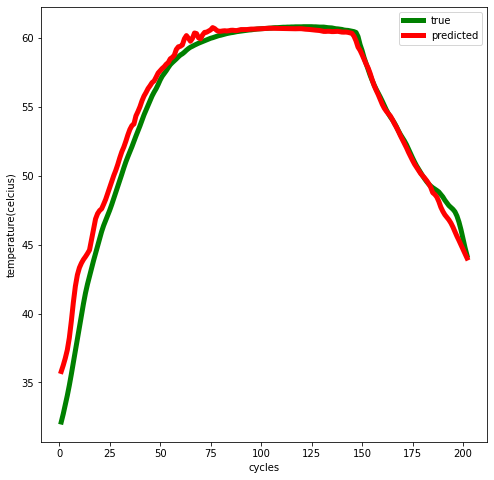

25


<Figure size 432x288 with 0 Axes>

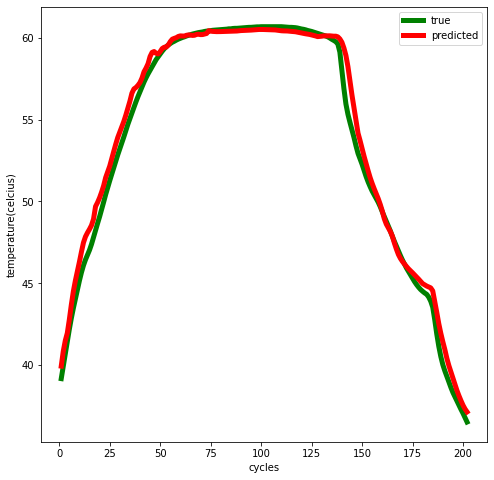

26


<Figure size 432x288 with 0 Axes>

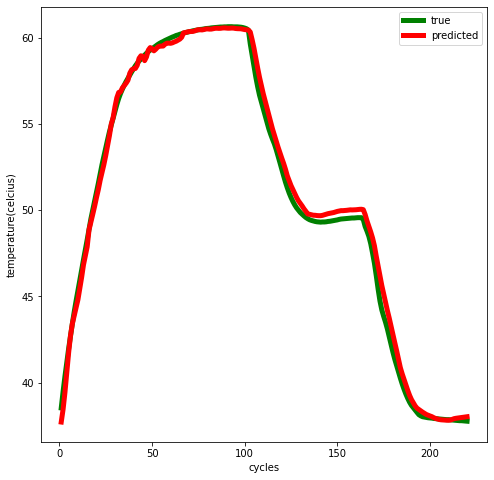

27


<Figure size 432x288 with 0 Axes>

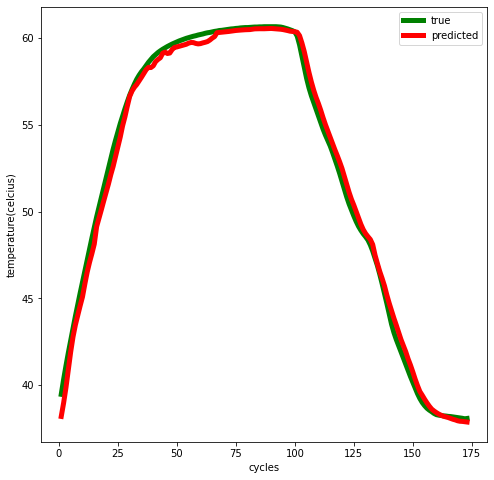

28


<Figure size 432x288 with 0 Axes>

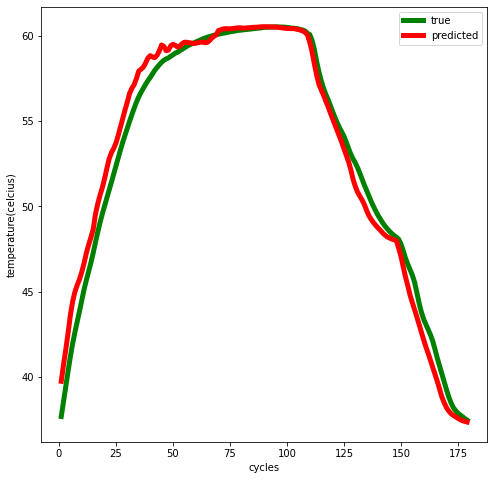

29


<Figure size 432x288 with 0 Axes>

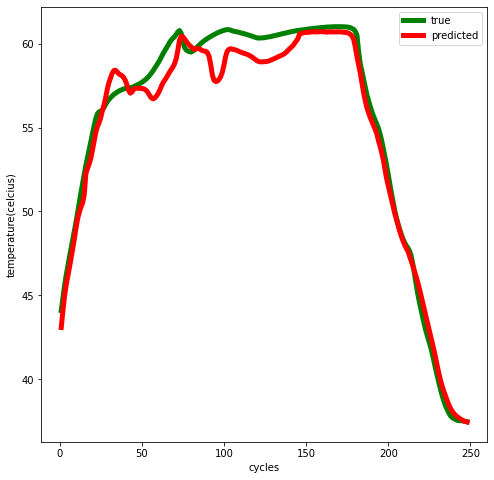

30


<Figure size 432x288 with 0 Axes>

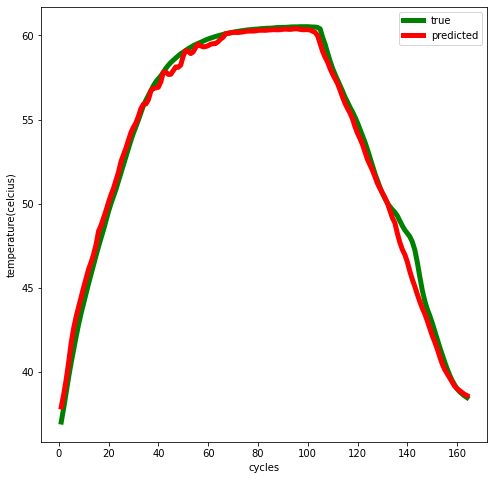

31


<Figure size 432x288 with 0 Axes>

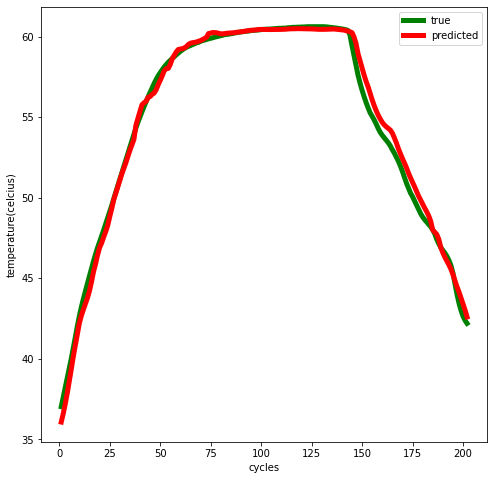

32


<Figure size 432x288 with 0 Axes>

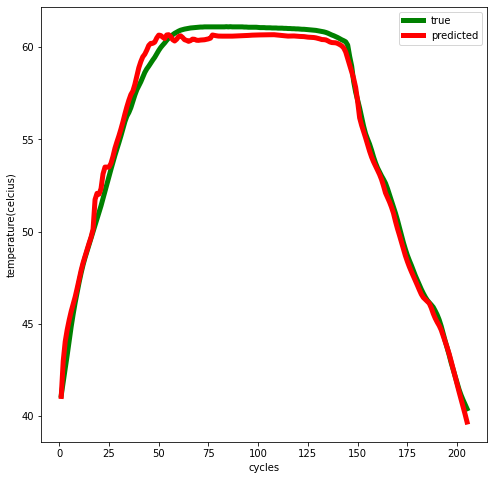

33


<Figure size 432x288 with 0 Axes>

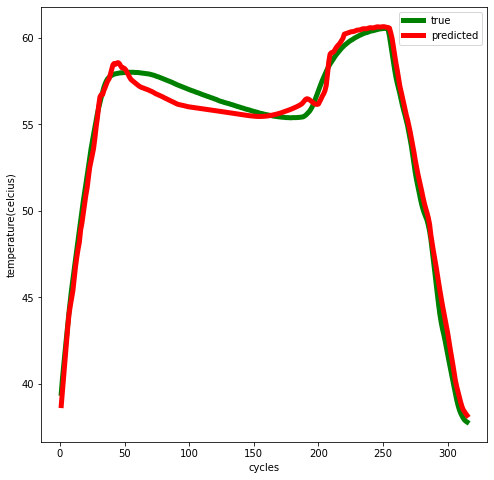

34


<Figure size 432x288 with 0 Axes>

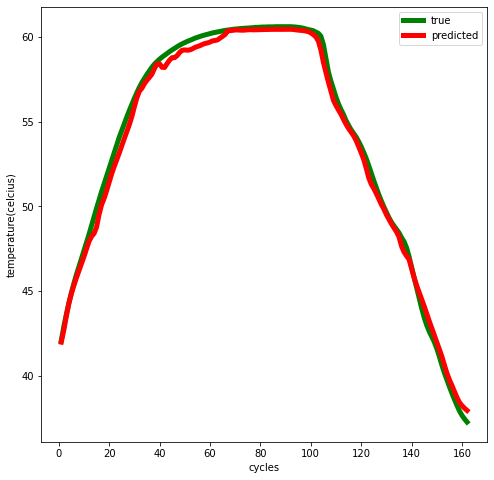

35


<Figure size 432x288 with 0 Axes>

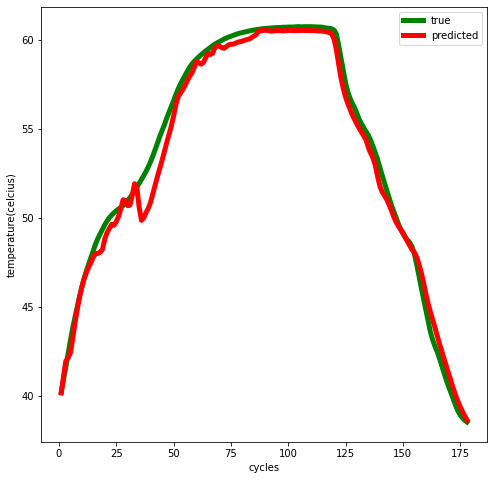

36


<Figure size 432x288 with 0 Axes>

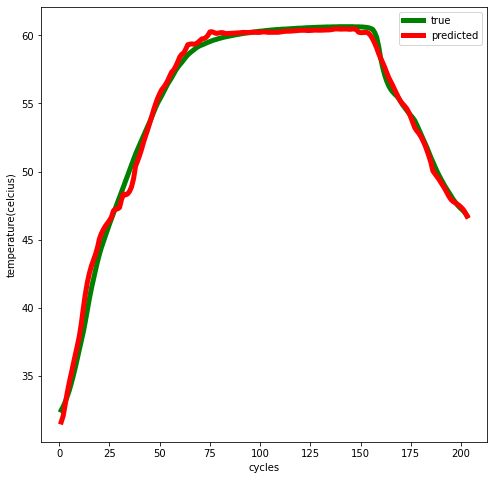

37


<Figure size 432x288 with 0 Axes>

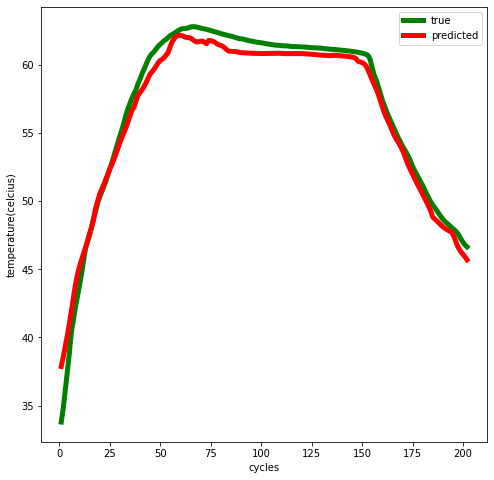

38


<Figure size 432x288 with 0 Axes>

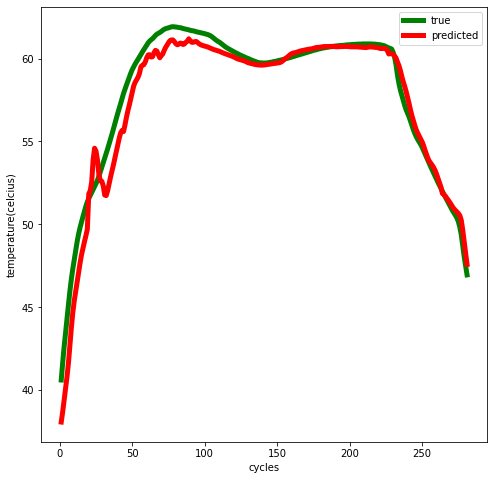

39


<Figure size 432x288 with 0 Axes>

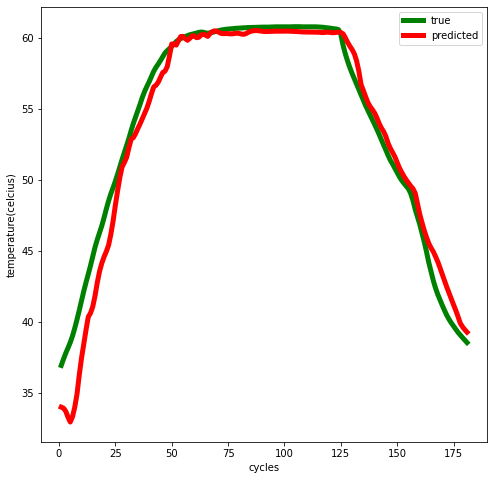

40


<Figure size 432x288 with 0 Axes>

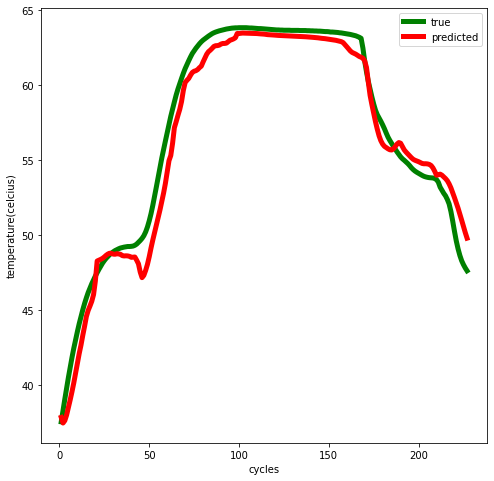

41


<Figure size 432x288 with 0 Axes>

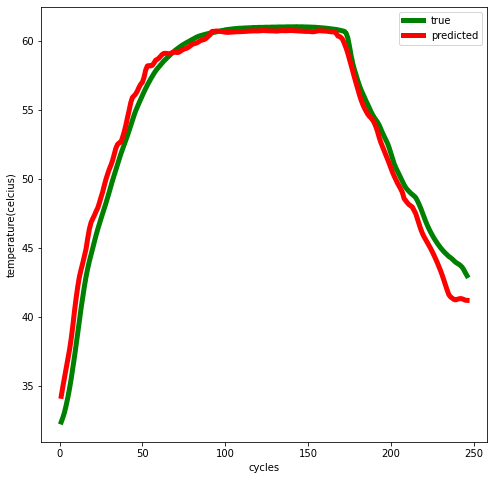

42


<Figure size 432x288 with 0 Axes>

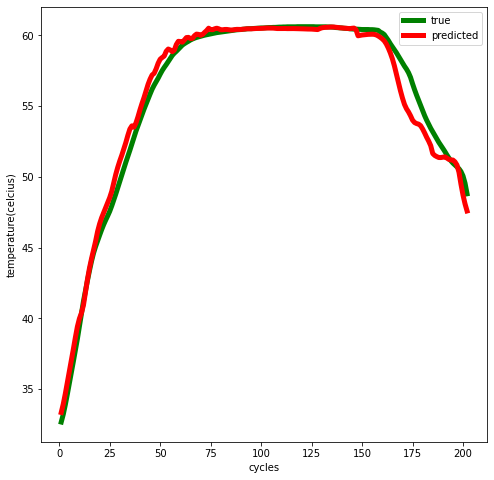

43


<Figure size 432x288 with 0 Axes>

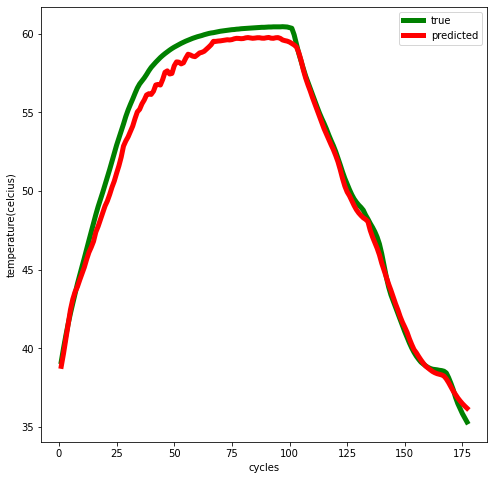

44


<Figure size 432x288 with 0 Axes>

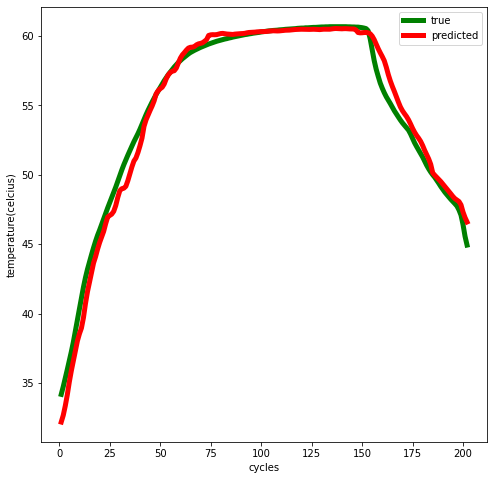

45


<Figure size 432x288 with 0 Axes>

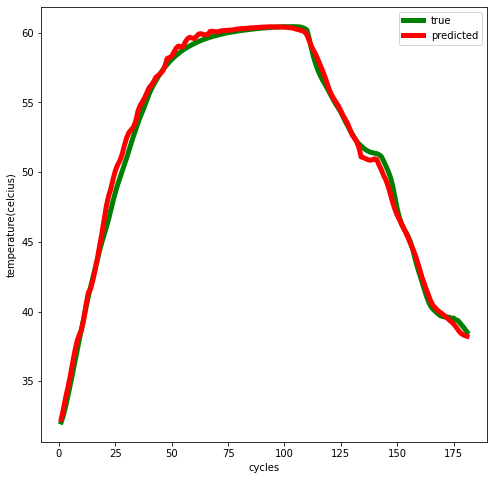

46


<Figure size 432x288 with 0 Axes>

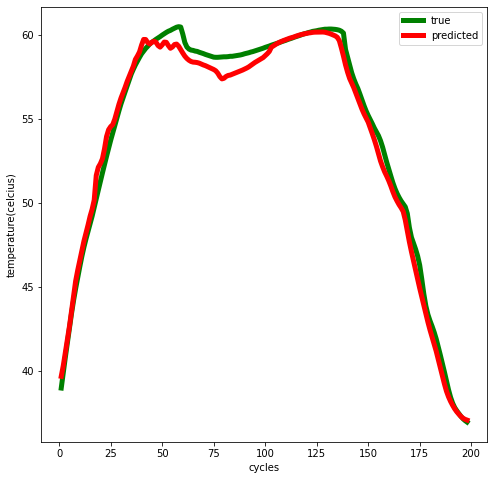

47


<Figure size 432x288 with 0 Axes>

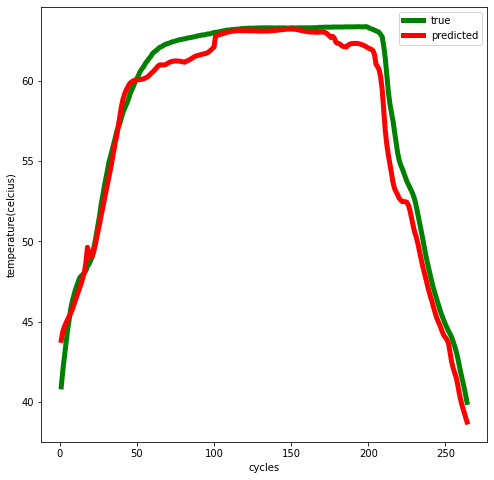

48


<Figure size 432x288 with 0 Axes>

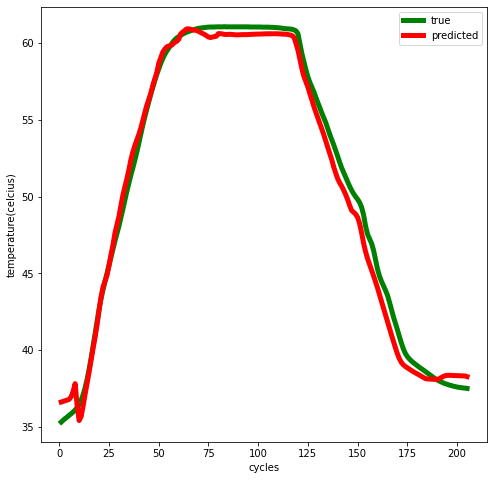

49


<Figure size 432x288 with 0 Axes>

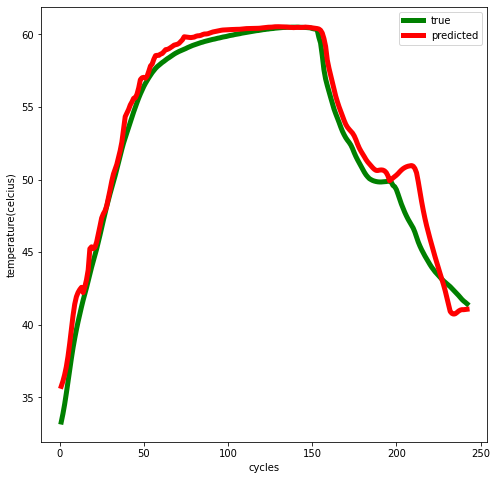

50


<Figure size 432x288 with 0 Axes>

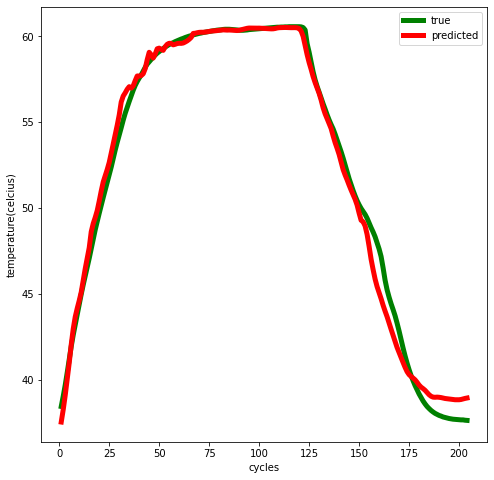

51


<Figure size 432x288 with 0 Axes>

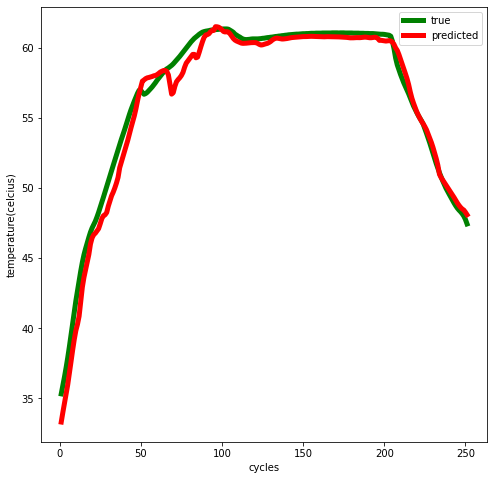

52


<Figure size 432x288 with 0 Axes>

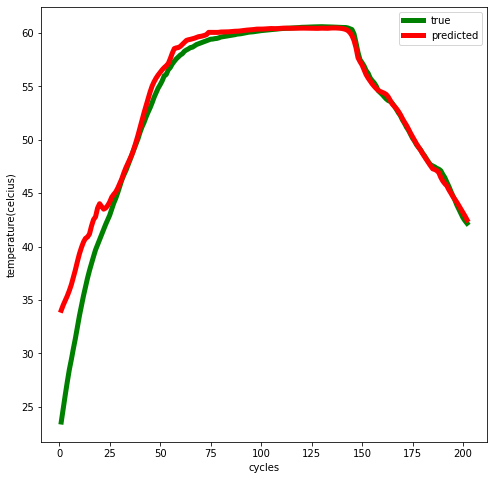

In [ ]:
# plot all predictions
for i in range(len(y_test_list)):
  print(i)
  my_plot(y_test_list[i],pred_list[i])